In [1]:
import pandas as pd

In [2]:
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 8)
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import sys; sys.path.append('../')
from PDE_FIND import *
import scipy.io as sio
import itertools

Populating the interactive namespace from numpy and matplotlib


## Diffusion Equation(1D Heat Equation)
$$u_t = D u{xx}$$
### Forward in time, central difference for space method(FTCS)
Discreticize this equation using forward difference for time and backward difference for space.
$$ \frac{u_j^{n+1}-u_j^n}{\Delta t} = D \frac{u_{j+1}^n - 2 u_j^n + u_{j-1}^n}{(\Delta x)^2}  $$
where $$ u_j^n = u(n \Delta t, j \Delta x)$$
Let $$ \alpha = D \frac{\Delta t}{(\Delta x)^2}$$
$$u_j^{n+1} = u_j^n - c \frac{\Delta t}{2 \Delta x}(u_{j+1}^n - u_{j-1}^n)$$

Text(0.5, 0, 't')

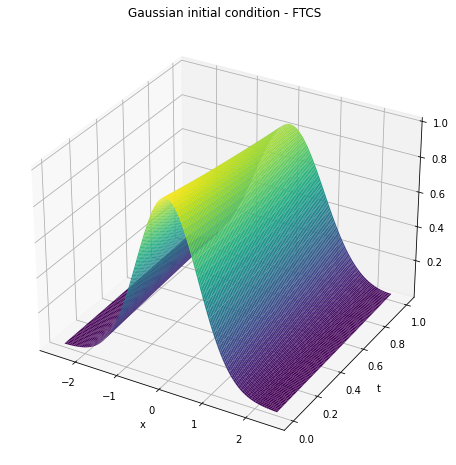

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Define the Gaussian initial condition
def GaussianInitial(x):
    x = np.array(x)
    return np.exp(-x**2)

# Parameters
D = 0.1 # Diffusion coefficient
L = 5.0  # Length of the domain
T = 1 # Total simulation time
N = 100  # Number of spatial grid points
M = 100  # Number of time steps
dx = L / N
dt = T / M
alpha = D * dt / dx**2

# Discretize spatial and time domains
x = np.linspace(-L/2, L/2, N+1)
t = np.linspace(0, T, M+1)

def exact_diff(t,x):
    global D
    a = 1 / np.sqrt(4*D*t +1)
    b = np.exp(-x**2/(4*D*t +1))
    u = a*b
    return u

def FTCS_diff(N, M, L, T, D, initial):
    
    dx = L / N
    dt = T / M
    alpha = D * dt / dx**2

    # Discretize spatial and time domains
    x = np.linspace(-L/2, L/2, N+1)
    t = np.linspace(0, T, M+1)

    # Initialize solution array and set initial condition
    U = np.zeros((N+1, M+1))
    U[:, 0] = initial(x)

    # Time-stepping using the FTCS method
    for n in range(0, M):
        for i in range(1, N):
            U[i, n+1] = U[i, n] + alpha * (U[i+1, n] - 2*U[i, n] + U[i-1, n])
        # Apply Neumann boundary conditions (zero gradient)
        U[0, n+1] = U[1, n+1]
        U[-1, n+1] = U[-2, n+1]
        
    return U

U = FTCS_diff(N, M, L, T, D, GaussianInitial)
# Create a meshgrid for plotting
T, X = np.meshgrid(t, x)

# Plotting the results in a 3D graph

ax = plt.axes(projection='3d')
ax.plot_surface(X, T, U, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none');
ax.set_title('Gaussian initial condition - FTCS')
ax.set_xlabel('x')
ax.set_ylabel('t')

Text(0.5, 0, 't')

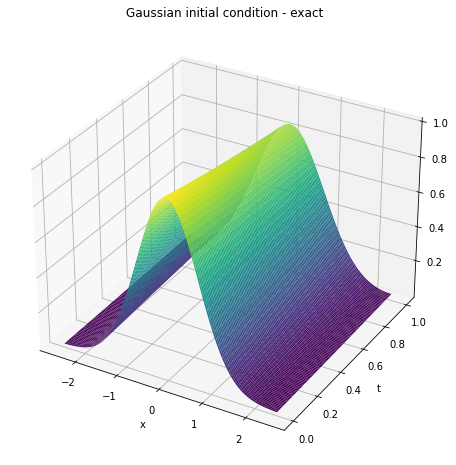

In [16]:
u = exact_diff(T,X)
ax = plt.axes(projection='3d')
ax.plot_surface(X, T, U, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none');
ax.set_title('Gaussian initial condition - exact')
ax.set_xlabel('x')
ax.set_ylabel('t')

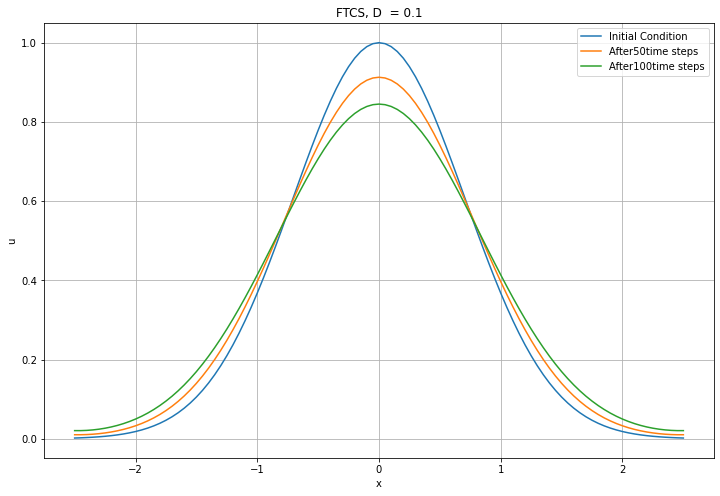

In [17]:
plt.figure()
plt.plot(x,U[:,0], label='Initial Condition')
plt.plot(x, U[:, int(M/2)], label='After' + str(int(M/2))+ 'time steps')
plt.plot(x, U[:, M], label='After' + str(M) + 'time steps')
plt.legend()
plt.title('FTCS, D  = ' + str(D))
plt.xlabel('x')
plt.ylabel('u')
plt.grid(True)
plt.show()

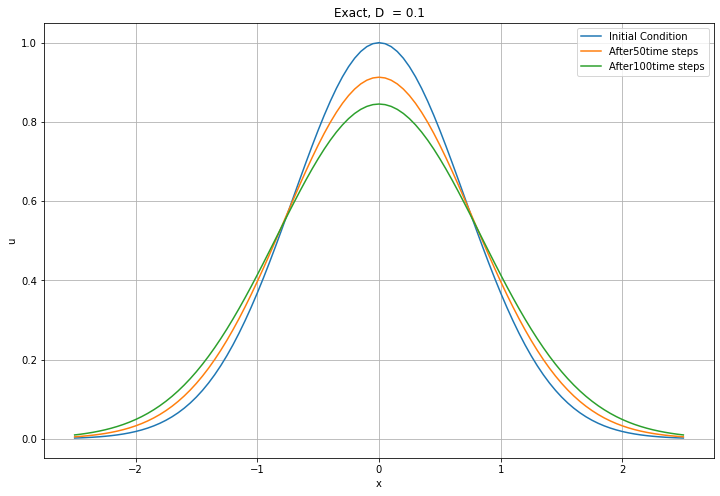

In [18]:
plt.figure()
plt.plot(x,u[:,0], label='Initial Condition')
plt.plot(x, u[:, int(M/2)], label='After' + str(int(M/2))+ 'time steps')
plt.plot(x, u[:, M], label='After' + str(M) + 'time steps')
plt.legend()
plt.title('Exact, D  = ' + str(D))
plt.xlabel('x')
plt.ylabel('u')
plt.grid(True)
plt.show()

### PDE-Discovery
Feed the generated data to PDE-Discovery, and try to discover the equation
$$ u_t = 0.1 u_{xx}$$

In [19]:
Ut, R, rhs_des = build_linear_system(U, dt, dx, D=3, P=3, time_diff = 'FD', space_diff = 'FD')
['1'] + rhs_des[1:]

['1',
 'u',
 'u^2',
 'u^3',
 'u_{x}',
 'uu_{x}',
 'u^2u_{x}',
 'u^3u_{x}',
 'u_{xx}',
 'uu_{xx}',
 'u^2u_{xx}',
 'u^3u_{xx}',
 'u_{xxx}',
 'uu_{xxx}',
 'u^2u_{xxx}',
 'u^3u_{xxx}']

In [20]:
# Solve with STRidge
w = TrainSTRidge(R,Ut,10**-5,0.1)
print("PDE derived using STRidge")
print_pde(w, rhs_des)

PDE derived using STRidge
u_t = (0.100211 +0.000000i)u_{xx}
   


In [21]:
err = abs((D - w[8])*100)
print("Parameter error:", err, '%')

Parameter error: [0.02105549] %


### Adding noises
Now try adding noises to the data.

In [22]:
numpy.random.seed(0)
un = U + 0.001*std(u)*np.random.randn(u.shape[0],u.shape[1])
Utn, Rn, rhs_des = build_linear_system(un, dt, dx, D=3, P=3, time_diff = 'poly', space_diff = 'FD')
['1'] + rhs_des[1:]
# Solve with STRidge
w = TrainSTRidge(Rn,Utn,10**-5,0.1)
print("PDE derived using STRidge")
print_pde(w, rhs_des)

PDE derived using STRidge
u_t = (0.705968 +0.000000i)u
    + (-1.837253 +0.000000i)u^2
    + (1.002706 +0.000000i)u^3
    + (-0.135100 +0.000000i)u^2u_{xx}
    + (0.170943 +0.000000i)u^3u_{xx}
   


Results show that the program fails when noise level is 0.001. We will further investigate the effects of noises in another Jupyter Notebook on Burger's equation.